In [2]:
# Copyright 2024 Google LLC
# 
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
# 
#     https://www.apache.org/licenses/LICENSE-2.0
# 
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import bigframes.pandas as bpd

bpd.options.bigquery.ordering_mode = "partial"
bpd.options.display.repr_mode = "deferred"

bpd.__version__

'1.27.0'

In [3]:
import warnings

import bigframes.exceptions

warnings.simplefilter("ignore", category=bigframes.exceptions.NullIndexPreviewWarning)
warnings.simplefilter("ignore", category=bigframes.exceptions.OrderingModePartialPreviewWarning)

In [4]:
df = bpd.read_gbq_table("bigquery-public-data.usa_names.usa_1910_current")

In [9]:
df.dtypes

state     string[pyarrow]
gender    string[pyarrow]
year                Int64
name      string[pyarrow]
number              Int64
dtype: object

In [10]:
df.year.max()

np.int64(2021)

In [7]:
df_2020 = df[df['year'] == 2020]

In [13]:
us_totals = (
    df_2020
    .groupby(["gender", "name"])
    .agg({"number": "sum"})
)
state_totals = (
    df_2020
    .groupby(["gender", "name", "state"])
    .agg({"number": "sum"})
)

In [15]:
# Most common names in 2020.
(
    us_totals
    .sort_values("number", ascending=False)
    .head(10)
    .to_pandas()
)

number
gender name             
M      Liam        19777
       Noah        18364
F      Olivia      17641
       Emma        15656
M      Oliver      14234
F      Ava         13160
M      Elijah      13136
F      Charlotte   13065
       Sophia      13036
       Amelia      12767

In [16]:
us_births = (
    df_2020
    .groupby(["gender"])
    .agg({"number": "sum"})
)
state_births = (
    df_2020
    .groupby(["gender", "state"])
    .agg({"number": "sum"})
)

In [31]:
us_proportions = us_totals / us_births
state_proportions = state_totals / state_births

In [19]:
import numpy as np

us_phi = 2 * np.arcsin(np.sqrt(us_proportions))
state_phi = 2 * np.arcsin(np.sqrt(state_proportions))

cohens_h = (
    (state_phi - us_phi)
    .rename(columns={"number": "cohens_h"})
    .assign(cohens_h_int=lambda _: (_['cohens_h'] * 1_000_000).astype("Int64"))
)

In [32]:
largest_per_state_and_gender = cohens_h.groupby(["gender", "state"]).agg({"cohens_h_int": "max"})
states = cohens_h[cohens_h['cohens_h_int'] == largest_per_state_and_gender["cohens_h_int"]]
states.to_pandas()

cohens_h  cohens_h_int
gender name      state                        
F      Savannah  CT     0.063943         63942
       Valentina FL     0.049368         49367
       Zo        AZ     0.049539         49539
M      Braxton   OH     0.041101         41101
       Braylen   NC     0.035844         35844
...                          ...           ...
F      Oakley    ID     0.095514         95513
M      Moshe     NY     0.084453         84452
F      Oakley    UT     0.102001        102000
       Emersyn   SD     0.111083        111082
       Emory     NC       0.0316         31600

[102 rows x 2 columns]

In [33]:
states_geo = bpd.read_gbq("bigquery-public-data.geo_us_boundaries.states")
states_geo.peek()

/home/swast/envs/scratch/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: UserWarning: Reading cached table from 2024-12-04 01:02:28.697670+00:00 to avoid incompatibilies with previous reads of this table. To read the latest version, set `use_cache=False` or close the current session with Session.close() or bigframes.pandas.close_session().
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/swast/envs/scratch/lib/python3.12/site-packages/bigframes/session/_io/bigquery/read_gbq_table.py:266: DefaultIndexWarning: Table 'bigquery-public-data.geo_us_boundaries.states' is clustered and/or partitioned, but BigQuery DataFrames was not able to find a suitable index. To avoid this warning, set at least one of: `index_col` or `filters`.
  warnings.warn(


,geo_id,region_code,division_code,state_fips_code,state_gnis_code,state,state_name,lsad_code,mtfcc_feature_class_code,functional_status,area_land_meters,area_water_meters,int_point_lat,int_point_lon,int_point_geom,state_geom
0,66,9,0,66,01802705,GU,Guam,00,G4000,A,543555844,934337453,13.441745,144.771902,POINT (144.7719 13.44175),"POLYGON ((144.56343 13.44806, 144.56355 13.445..."
1,72,9,0,72,01779808,PR,Puerto Rico,00,G4000,A,8868701898,4922576715,18.217648,-66.410799,POINT (-66.4108 18.21765),"MULTIPOLYGON (((-67.54302 18.38612, -67.54244 ..."
2,69,9,0,69,01779809,MP,Commonwealth of the Northern Mariana Islands,00,G4000,A,472292529,4644252458,14.936784,145.601021,POINT (145.60102 14.93678),"MULTIPOLYGON (((145.70117 16.72411, 145.70003 ..."
3,78,9,0,78,01802710,VI,United States Virgin Islands,00,G4000,A,348021896,1550236199,18.326748,-64.971251,POINT (-64.97125 18.32675),"MULTIPOLYGON (((-64.95671 17.67898, -64.95649 ..."
4,60,9,0,60,01802701,AS,American Samoa,00,G4000,A,197759069,1307243751,-14.267159,-170.668267,POINT (-170.66827 -14.26716),"MULTIPOLYGON (((-170.79716 -14.24664, -170.799..."


In [34]:
states_plus = (
    states
    .reset_index(drop=False)
    .merge(states_geo, on="state", how="left")
    .to_pandas()
)

1          Annotation(-158.11, 20.9951, 'Kainalu')
2        Annotation(-151.601, 63.7366, 'Theodore')
4         Annotation(-120.605, 43.9405, 'Unknown')
6        Annotation(-120.593, 47.4116, 'Theodore')
9           Annotation(-119.664, 37.2153, 'Mateo')
11       Annotation(-116.655, 39.3562, 'Leonardo')
13         Annotation(-114.659, 44.3891, 'Oliver')
15         Annotation(-111.678, 39.3238, 'Boston')
16          Annotation(-111.664, 34.2931, 'Jesus')
18          Annotation(-109.645, 47.0334, 'Wyatt')
20          Annotation(-107.551, 42.9995, 'Wyatt')
23        Annotation(-106.108, 34.4213, 'Ezekiel')
25       Annotation(-105.548, 38.9985, 'Theodore')
26         Annotation(-100.469, 47.4463, 'Briggs')
29           Annotation(-100.23, 44.4361, 'Rhett')
31          Annotation(-99.8109, 41.5271, 'Ryker')
33           Annotation(-99.3171, 31.4472, 'Jose')
35         Annotation(-98.3802, 38.4847, 'Brooks')
37          Annotation(-97.5082, 35.5835, 'Ryker')
39     Annotation(-94.1983, 46.

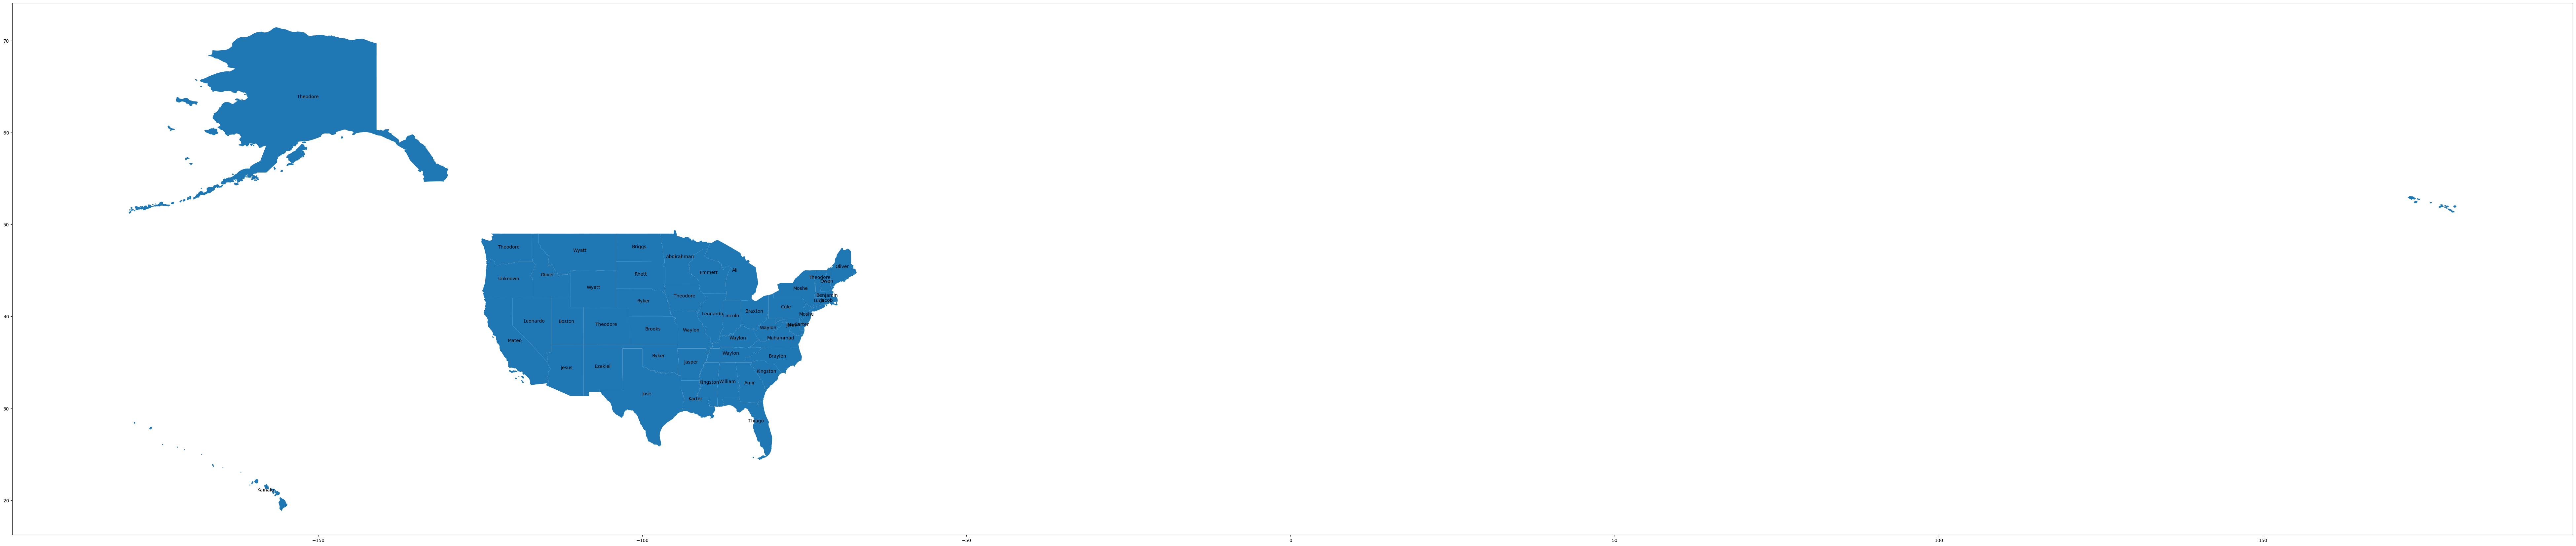

In [37]:
import geopandas

states_plus = geopandas.GeoDataFrame(states_plus, geometry="state_geom")
males = states_plus[states_plus['gender'] == 'M']

# https://stackoverflow.com/a/42214156/101923
ax = males.plot(figsize=(100, 100))
males.apply(
    lambda row: ax.annotate(
        text=row['name'],
        xy=row['state_geom'].centroid.coords[0],
        ha='center'
    ),
    axis=1,
)

0           Annotation(-158.11, 20.9951, 'Halia')
3         Annotation(-151.601, 63.7366, 'Aurora')
5        Annotation(-120.605, 43.9405, 'Juniper')
7        Annotation(-120.593, 47.4116, 'Juniper')
8         Annotation(-119.664, 37.2153, 'Camila')
10        Annotation(-116.655, 39.3562, 'Athena')
12        Annotation(-114.659, 44.3891, 'Oakley')
14        Annotation(-111.678, 39.3238, 'Oakley')
17            Annotation(-111.664, 34.2931, 'Zo')
19          Annotation(-109.645, 47.0334, 'Nora')
21        Annotation(-107.551, 42.9995, 'Oakley')
22          Annotation(-106.108, 34.4213, 'Aria')
24         Annotation(-105.548, 38.9985, 'Aspen')
27         Annotation(-100.469, 47.4463, 'Hazel')
28        Annotation(-100.23, 44.4361, 'Emersyn')
30         Annotation(-99.8109, 41.5271, 'Willa')
32        Annotation(-99.3171, 31.4472, 'Camila')
34       Annotation(-98.3802, 38.4847, 'Brecken')
36       Annotation(-97.5082, 35.5835, 'Blakely')
38         Annotation(-94.1983, 46.3493, 'Greta')


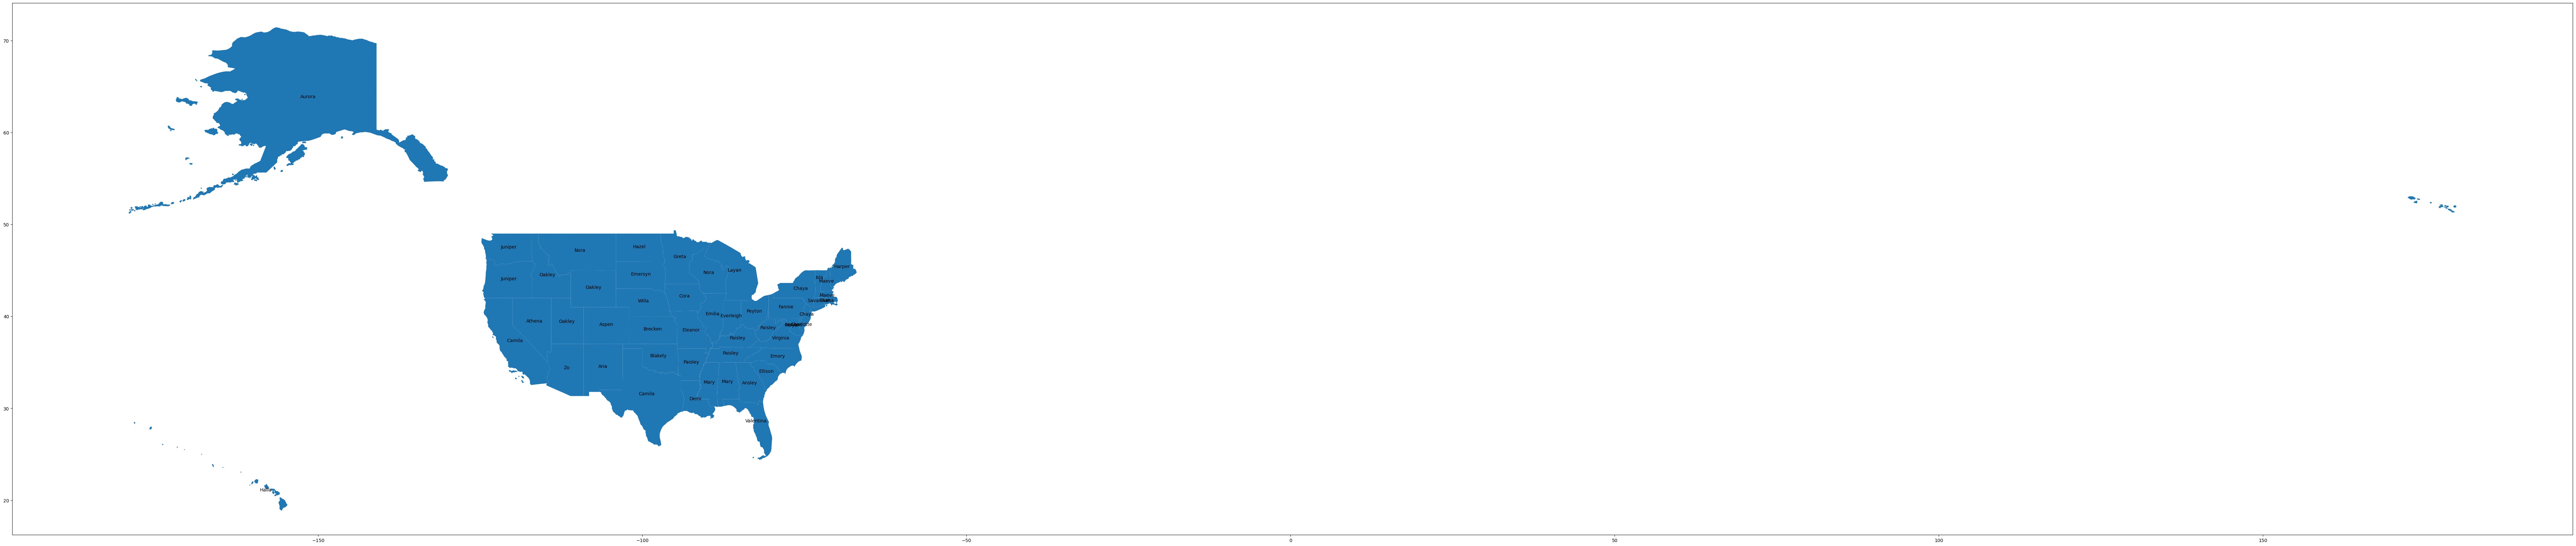

In [38]:
females = states_plus[states_plus['gender'] == 'F']

# https://stackoverflow.com/a/42214156/101923
ax = females.plot(figsize=(100, 100))
females.apply(
    lambda row: ax.annotate(
        text=row['name'],
        xy=row['state_geom'].centroid.coords[0],
        ha='center'
    ),
    axis=1,
)